<a href="https://colab.research.google.com/github/trungnt13/sisua/blob/master/sisua/tutorials/notebook/SISUA_basic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install sisua==0.4.3

# Import all the necessary libraries

NOTE: if for any reason you encounter exception during running this block

Go to `Runtime` => `Restart and run all ...`, so all the new libraries are loaded.

In [0]:
from __future__ import absolute_import, division, print_function

import os

import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sisua.analysis import Posterior
from sisua.data import get_dataset, standardize_protein_name
from sisua.models import (SCVI, DeepCountAutoencoder, MultitaskVAE,
                          VariationalAutoEncoder)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.random.set_seed(8)
np.random.seed(8)

### Configuration for the model and training

In [0]:
# The configurations for SISUA paper are:
# nlayers = 1
# hdim = 128
# zdim = 32
# However, it is recommended to keep this number as is if you run the code
# on Google Colab
nlayers = 1
hdim = 64
zdim = 16
epochs = 64

# Loading the data

The code is divided into 2 steps:

* First, we load the dataset using `get_dataset({dataset_id})`
* Second, we split the dataset into two mutual exclusive set for training and testing (repeated for both gene expression data and protein marker data)

The list of all datasets and their description can be find [here](https://htmlpreview.github.io/?https://github.com/trungnt13/sisua/blob/master/description/dataset.html)


In [9]:
x, y = get_dataset('pbmc8kly')
print(x)
print(y)

x_train, x_test = x.split(train_percent=0.9)
y_train, y_test = y.split(train_percent=0.9)

x_train.assert_matching_cells(y_train)
x_test.assert_matching_cells(y_test)

n_genes = x.shape[1]
n_prots = y.shape[1]

pbmc8kly with n_obs × n_vars = 4697 × 1998 
    obs: 'cellid'
    var: 'geneid'
    Sparsity: 0.91
    Nonzeros: {#:886159|mi:1.00|q1:1.00|md:1.00|mn:4.45|q3:3.00|ma:181.00|sd:9.47}
    Cell    : {#:4697|mi:223.00|q1:678.00|md:816.00|mn:840.27|q3:979.00|ma:2042.00|sd:225.08}
    Gene    : {#:1998|mi:2.00|q1:25.25|md:156.50|mn:1975.35|q3:597.75|ma:250123.00|sd:12899.47}
    TotalCount: {#:4697|mi:223.00|q1:678.00|md:816.00|mn:840.27|q3:979.00|ma:2042.00|sd:225.08}
    LogCount  : {#:4697|mi:5.41|q1:6.52|md:6.70|mn:6.70|q3:6.89|ma:7.62|sd:0.27}
    LocalMean : {#:4697|mi:6.70|q1:6.70|md:6.70|mn:6.70|q3:6.70|ma:6.70|sd:0.00}
    LocalVar  : {#:4697|mi:0.07|q1:0.07|md:0.07|mn:0.07|q3:0.07|ma:0.07|sd:0.00}
pbmc8kly with n_obs × n_vars = 4697 × 12 
    obs: 'cellid'
    var: 'protid'
    Sparsity: 0.00
    Nonzeros: {#:56267|mi:0.53|q1:3.13|md:3.83|mn:4.58|q3:6.09|ma:9.11|sd:2.07}
    Cell    : {#:4697|mi:47.57|q1:52.44|md:54.42|mn:54.89|q3:57.10|ma:68.44|sd:3.20}
    Gene    : {#:12|mi:1162

# Create and train a single-cell Variational Autoencoder

In [10]:
scvae = VariationalAutoEncoder(units=n_genes,
                               xdist='zinb',
                               nlayers=nlayers,
                               hdim=hdim,
                               zdim=zdim)
# Be generous with the number of epoch, since we use EarlyStopping,
# the algorithm will stop when overfitting
scvae.fit(x_train, epochs=epochs, verbose=True)

imputation, latent = scvae.predict(x_test)
# instead of getting a single imputation, we get a distribution of
# the imputation, which is much more helpful
print(imputation)
print(latent)

Epoch 1/64
60/60 [==============================] - 6s 106ms/step - loss: 1129.1437 - KLqp: 0.6953 - nllk_x: 1172.8046 - val_loss: 1066.5693 - val_KLqp: 0.2549 - val_nllk_x: 1066.5642
Epoch 2/64
60/60 [==============================] - 4s 59ms/step - loss: 980.8550 - KLqp: 0.6936 - nllk_x: 1011.2608 - val_loss: 943.6983 - val_KLqp: 0.3058 - val_nllk_x: 943.6923
Epoch 3/64
60/60 [==============================] - 4s 60ms/step - loss: 869.7636 - KLqp: 0.7118 - nllk_x: 893.5247 - val_loss: 840.4605 - val_KLqp: 0.3747 - val_nllk_x: 840.4455
Epoch 4/64
60/60 [==============================] - 4s 60ms/step - loss: 784.6700 - KLqp: 0.7348 - nllk_x: 804.7759 - val_loss: 754.8391 - val_KLqp: 0.4720 - val_nllk_x: 754.8109
Epoch 5/64
60/60 [==============================] - 4s 60ms/step - loss: 718.5212 - KLqp: 0.7628 - nllk_x: 730.6331 - val_loss: 703.1140 - val_KLqp: 0.5267 - val_nllk_x: 703.0718
Epoch 6/64
60/60 [==============================] - 4s 60ms/step - loss: 672.0917 - KLqp: 0.7862 - 

Predicting: 100%|██████████| 8/8 [00:00<00:00, 10.20it/s]

tfp.distributions.Independent("IndependentZeroInflated", batch_shape=[1, 470], event_shape=[1998], dtype=float32)
tfp.distributions.Independent("IndependentNormal", batch_shape=[470], event_shape=[16], dtype=float32)


### Performing analysis of trained model is simple in SISUA

A `Posterior` class is created using:

* A trained `SingleCellModel`
* Test data

The `Posterior` provides ultilities for inspecting the training progress, and analyzing the latent space, imputation space and predicted protein (in semi-supervised case)

Predicting: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


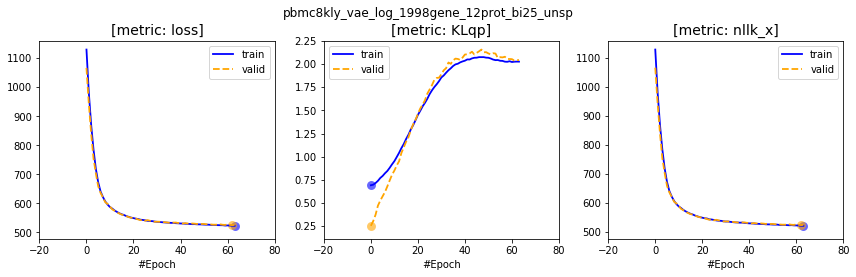

In [11]:
pos = Posterior(scvae, gene=x_test, protein=y_test, verbose=True)
# inspecting training process
pos.plot_learning_curves(metrics=['loss', 'klqp', 'loss_x', 'nllk_x'],
                         fig=(12, 4))

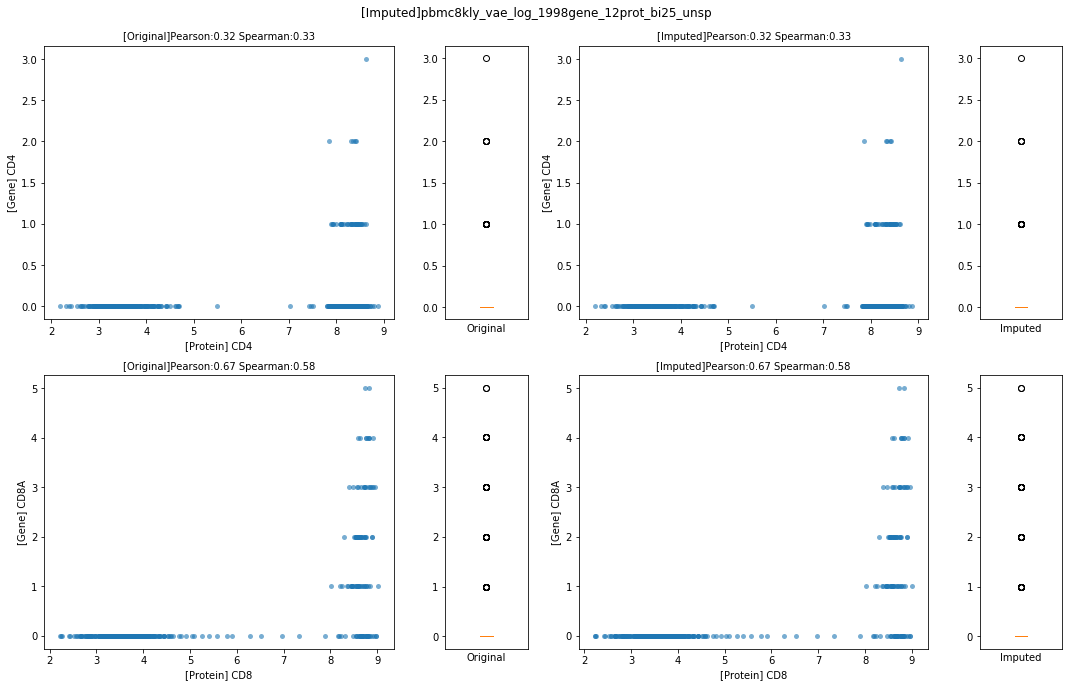

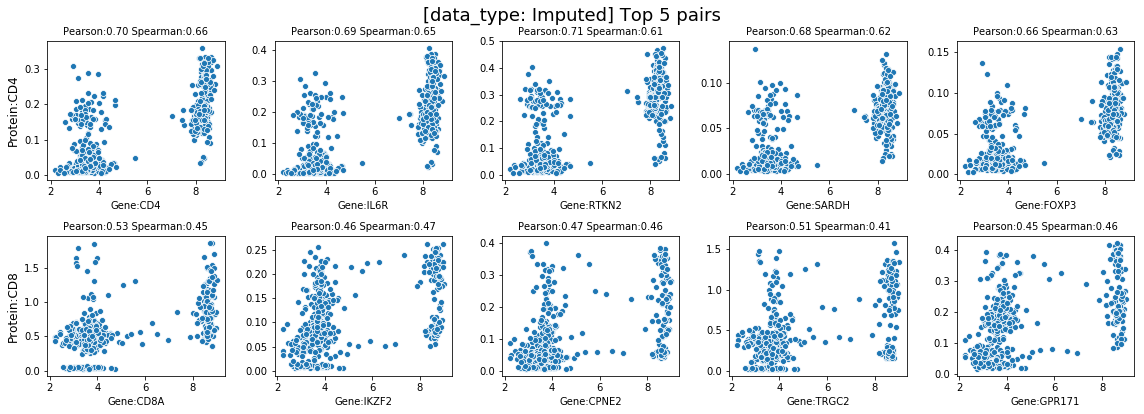

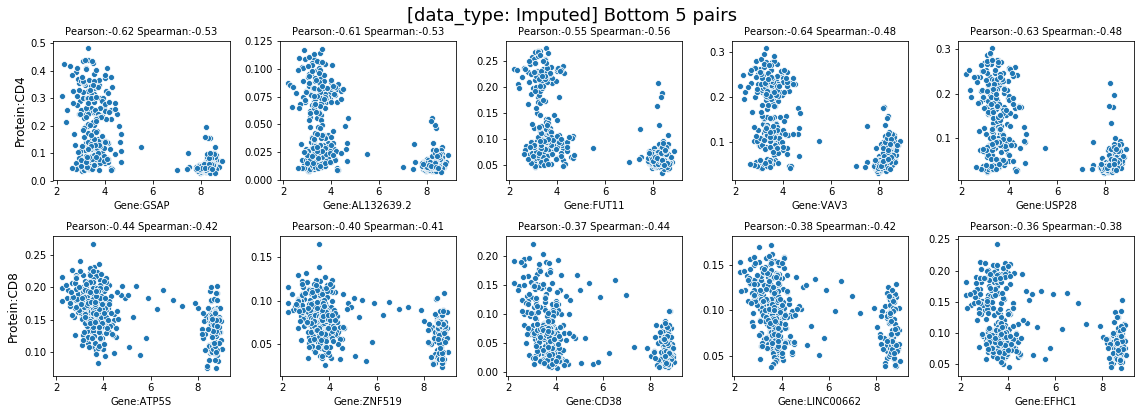

In [12]:
# the analysis of marker proteins (if available)
proteins = ['cd4', 'cd8']
pos.plot_correlation_marker_pairs(imputed=True, proteins=proteins)
pos.plot_correlation_top_pairs(n=5, proteins=proteins, fig=(16, 6))
pos.plot_correlation_bottom_pairs(n=5, proteins=proteins, fig=(16, 6))

[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
Predicting: 100%|██████████| 265/265 [00:47<00:00,  5.55it/s]


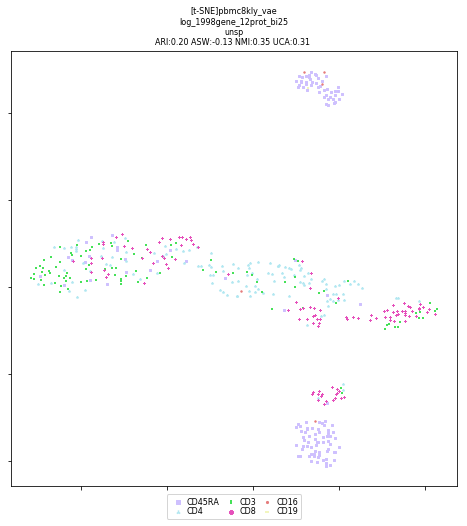

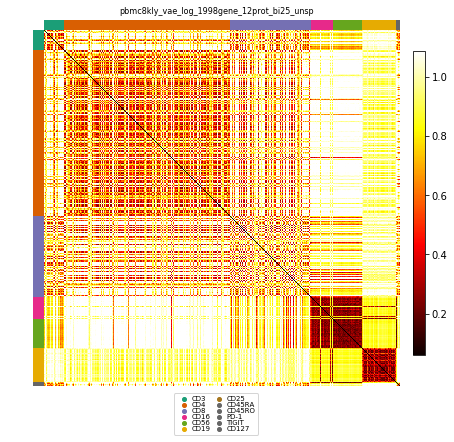

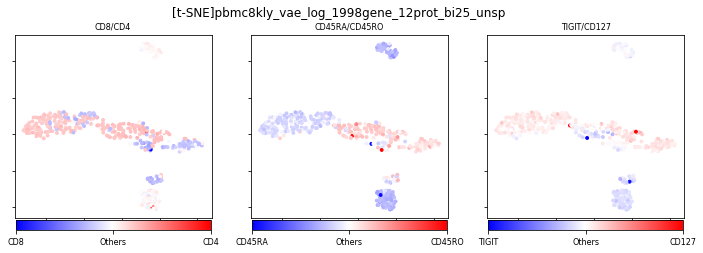

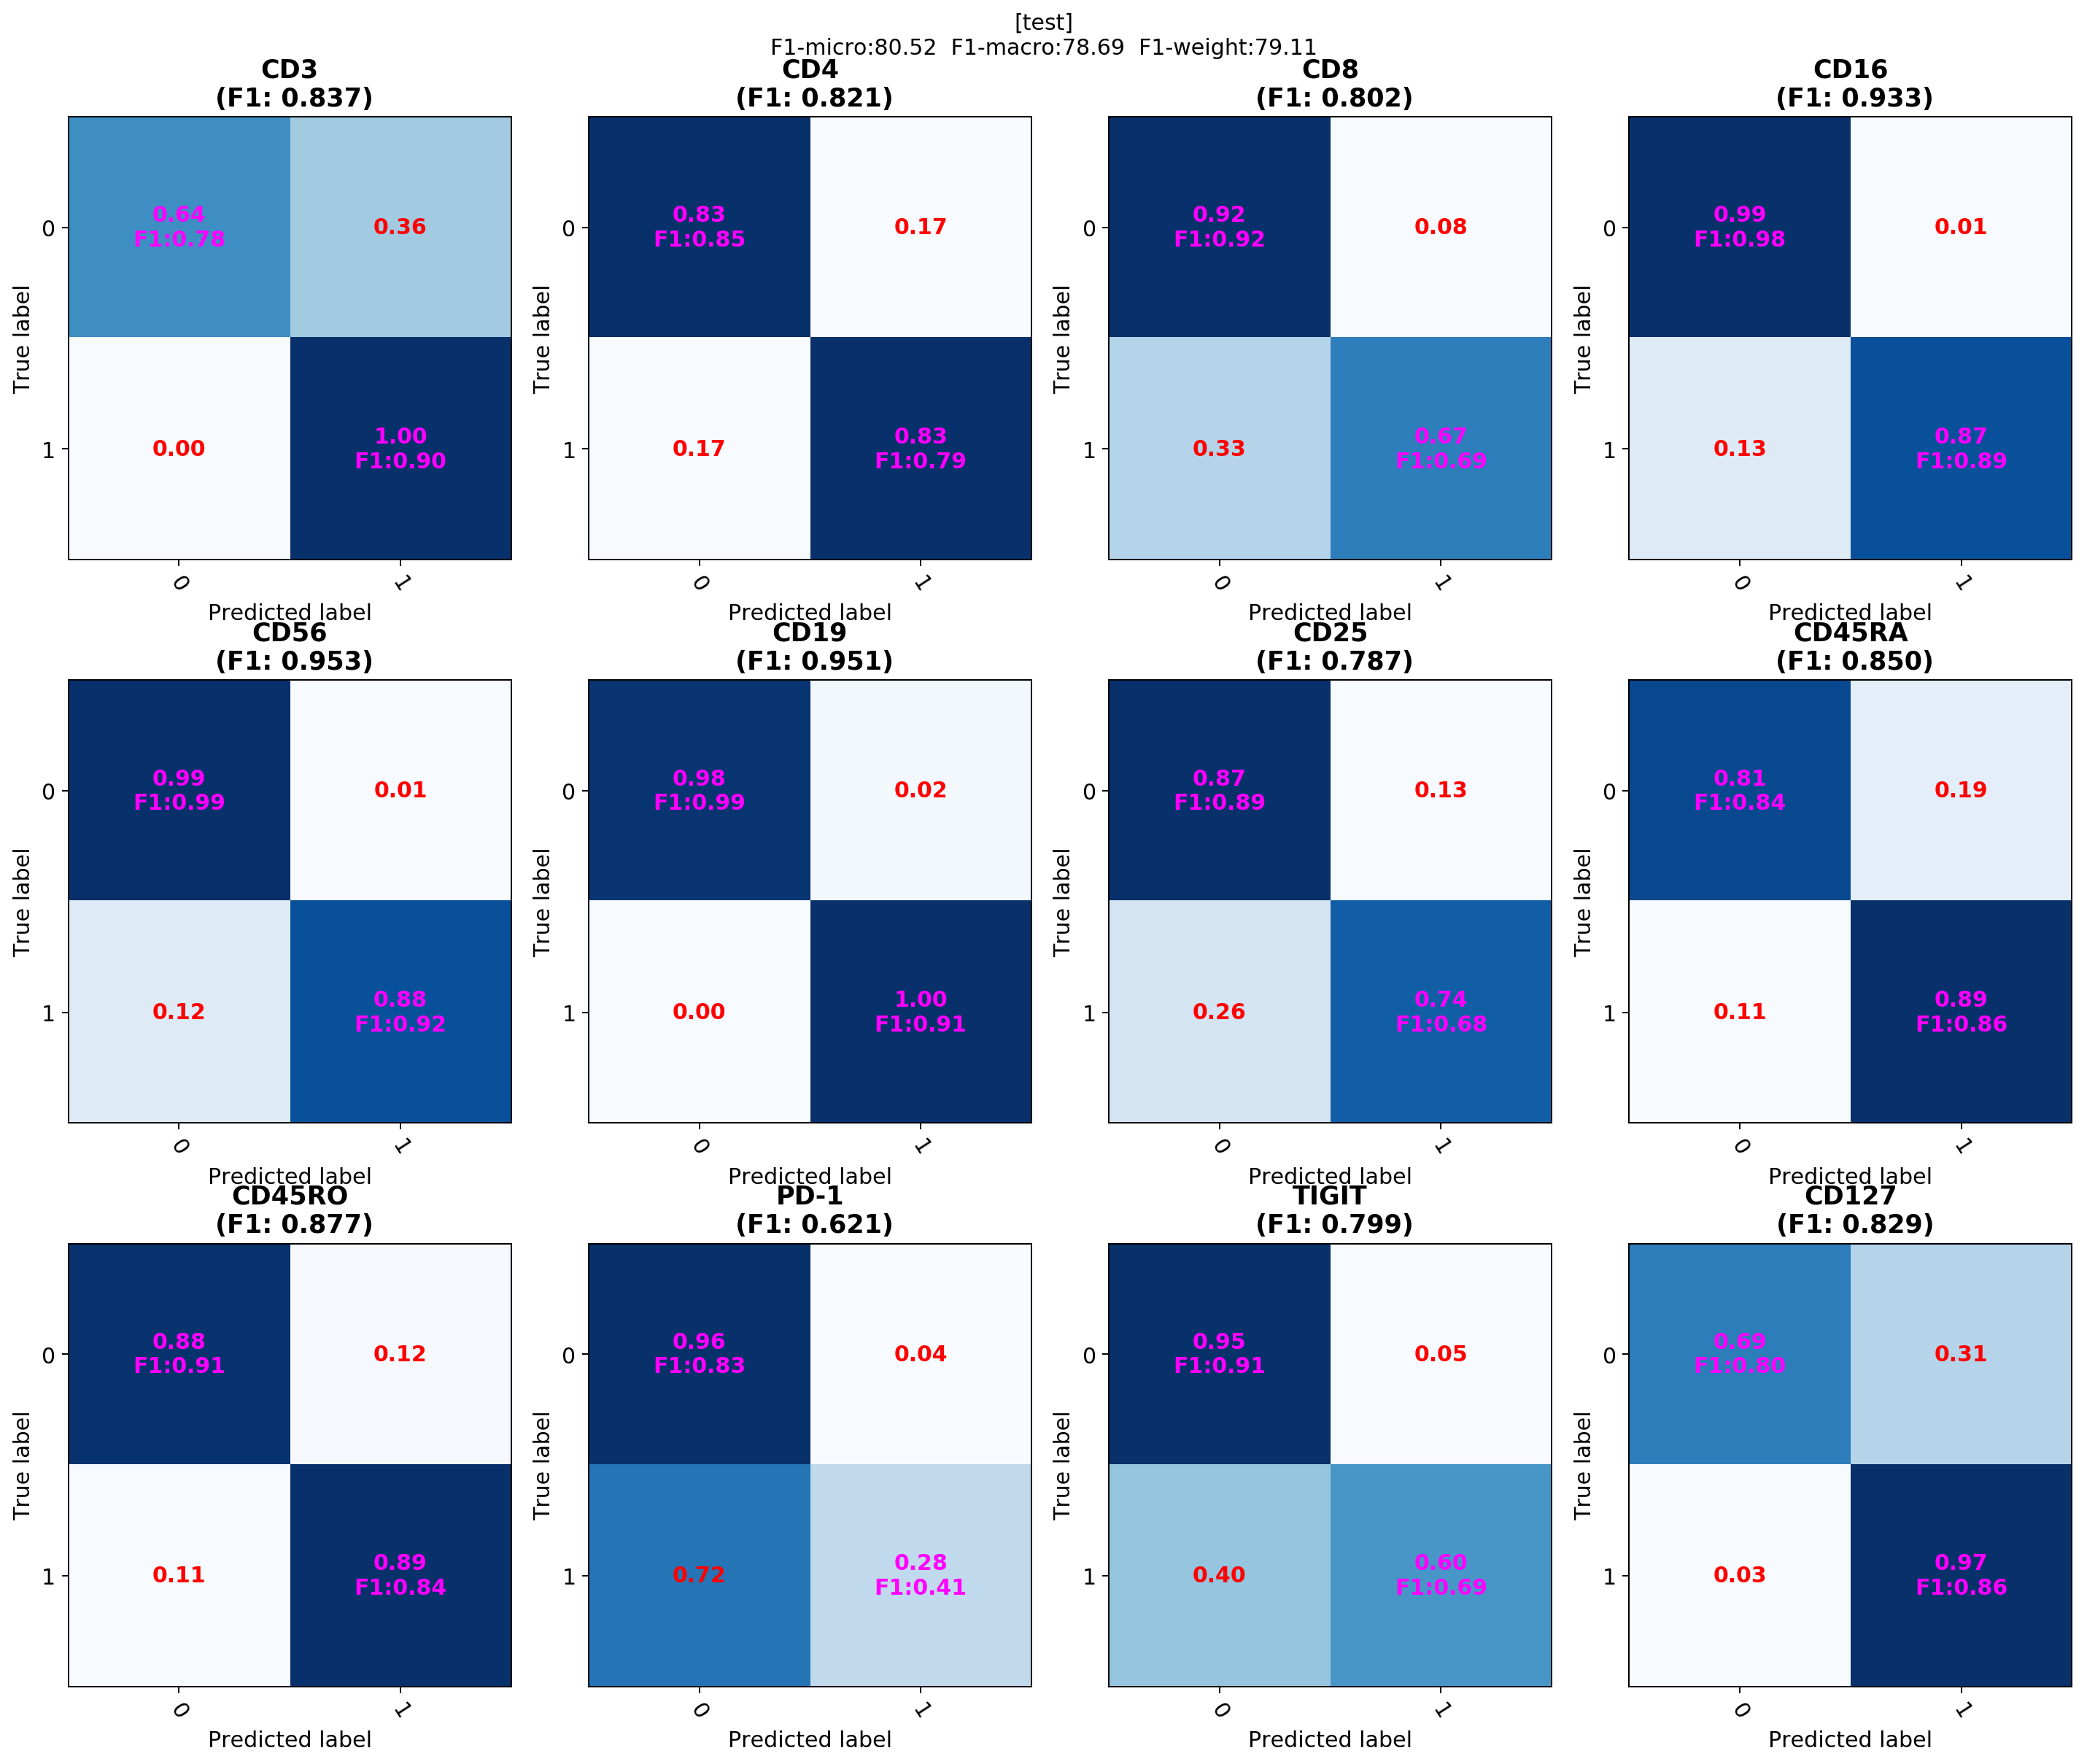

In [13]:
# the analysis of latent space
pos.plot_latents_binary_scatter()
pos.plot_latents_distance_heatmap()
pos.plot_latents_protein_pairs()
pos.plot_classifier_F1(x_train=x_train, y_train=y_train)

In [0]:
# all figure and analysis could be saved to pdf file for later inspectation
# pos.save_figures('/tmp/tmp.pdf')

# SISUA provide a generalized implementation of deep count autoencoder (DCA)


In SISUA, the class `DeepCountAutoencoder` could have deterministic or stochastic loss

The option `xdist` will determine which loss is applied on the input distribution:

* A list of all deterministic losses could be found at `tensorflow.losses` [link](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses), it is basically the measure of distance between reconstructed data and the input data (i.e. the gene expression in our case)
* The stochastic loss is the negative log-likelihood of the predicted distribution to the input data

SISUA support most of the distribution in [`tensorflow_probability`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions), however, the following are mostly used:

* _nb_ : Negative Binomial
* _nbd_ : Negative Binomial parameterization by mean and dispersion (often used in the bioinformatic field)
* _zinb_ : Zero-inflated Negative Binomial
* _zinbd_ : Zero-inflated Negative Binoial (mean and dispersion)
* _pois_ : Poisson
* _zipois_ : Zero-inflated Poisson distribution
* _normal_ : Gaussian distribution

Reference: 
* [Eraslan G., Simon L. M., Mircea M., et al. "Single-cell RNA-seq denoising using a deep count autoencoder". Nature Communications, volume 10, 390 (2019).](https://www.nature.com/articles/s41467-018-07931-2)


In [14]:
# deterministic loss
dca_detr = DeepCountAutoencoder(units=n_genes,
                                xdist='mse',
                                nlayers=nlayers,
                                hdim=hdim,
                                zdim=zdim)
dca_detr.fit(x_train, epochs=epochs, verbose=False)
imputation_dca1, latent_dca1 = dca_detr.predict(x_test)

# stochastic loss
dca_stch = DeepCountAutoencoder(units=n_genes,
                                xdist='zinb',
                                nlayers=nlayers,
                                hdim=hdim,
                                zdim=zdim)
dca_stch.fit(x_train, epochs=epochs, verbose=False)
imputation_dca2, latent_dca2 = dca_stch.predict(x_test)

# both model return a distribution, which is well generalized by the SISUA
# framework, however, there is important different when you sampling from
# imputation distribution
print(imputation_dca1)
print(imputation_dca2)

Predicting: 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]

tfp.distributions.VectorDeterministic("VectorDeterministic", batch_shape=[1, 470], event_shape=[1998], dtype=float32)
tfp.distributions.Independent("IndependentZeroInflated", batch_shape=[1, 470], event_shape=[1998], dtype=float32)


### Visualizing the different between deterministic and stochastic DCA

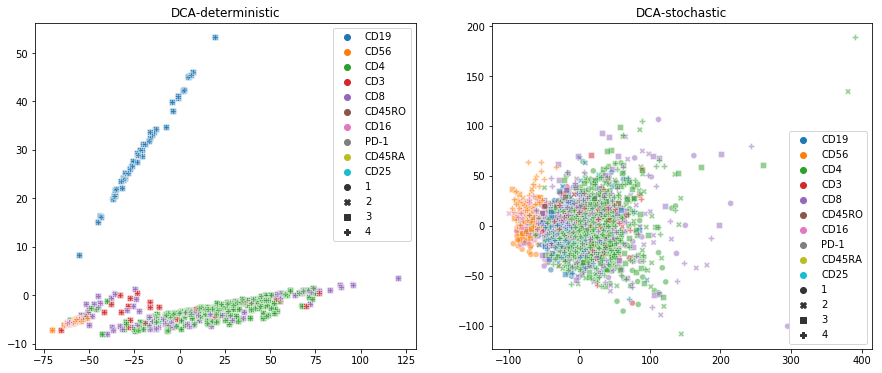

In [15]:
# sample and plot the differences
n = 4
sample1 = imputation_dca1.sample(n).numpy()
sample2 = imputation_dca2.sample(n).numpy()
labels = np.argmax(y_test.probabilistic_embedding().obsm['X_prob'], axis=1)
labels_name = [standardize_protein_name(i) for i in y_test.var['protid']]
labels = [labels_name[i] for i in labels]

plt.figure(figsize=(15, 6))
for fig_id, (model_name, sample) in enumerate([("DCA-deterministic", sample1),
                                               ("DCA-stochastic", sample2)]):
  x = []
  y = []
  index = []
  label = []
  for i, s in enumerate(sample):
    s = np.squeeze(s, axis=0)

    pca = PCA(n_components=2, random_state=8).fit_transform(s)
    x.append(pca[:, 0])
    y.append(pca[:, 1])

    index.append(np.full(shape=(s.shape[0],), fill_value=i + 1, dtype='int32'))

    label.append(labels)

  x = np.concatenate(x, axis=0)
  y = np.concatenate(y, axis=0)
  index = np.concatenate(index, axis=0)
  label = np.concatenate(label, axis=0)

  ax = plt.subplot(1, 2, fig_id + 1)
  sns.scatterplot(x='x',
                  y='y',
                  hue='label',
                  style='sample',
                  alpha=0.5,
                  data={
                      'x': x,
                      'y': y,
                      'label': label,
                      'sample': index
                  },
                  ax=ax)
  ax.set_title(model_name)

# scVI implemented in tensorflow and SISUA

For `scVI` two latents are returned:

* The library size **L** `[n_samples, 1]`
* And the latent representation **Z** `[n_samples, zdim]`

Reference:

* [Romain Lopez, Jeffrey Regier, Michael Cole, Michael I. Jordan, Nir Yosef. "Deep generative modeling for single-cell transcriptomics." Nature Methods, 2018.](https://rdcu.be/bdHYQ)

In [16]:
# Another parameterization of Negative Binomial distribution must be used
# for scVI, i.e. Negative Binomial with mean and 'D'ispersion parameters
scvi = SCVI(units=n_genes, xdist='zinbd', nlayers=nlayers, hdim=hdim, zdim=zdim)
scvi.fit(x_train, epochs=epochs, verbose=False)
imputation, (latent, log_library) = scvi.predict(x_test)
print(imputation)
print(latent)
print(log_library)

Predicting: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


tfp.distributions.Independent("IndependentZeroInflated", batch_shape=[1, 470], event_shape=[1998], dtype=float32)
tfp.distributions.Independent("IndependentNormal", batch_shape=[470], event_shape=[16], dtype=float32)
tfp.distributions.Independent("IndependentNormal", batch_shape=[470], event_shape=[1], dtype=float32)


### Check how efficient scVI modeling the library size

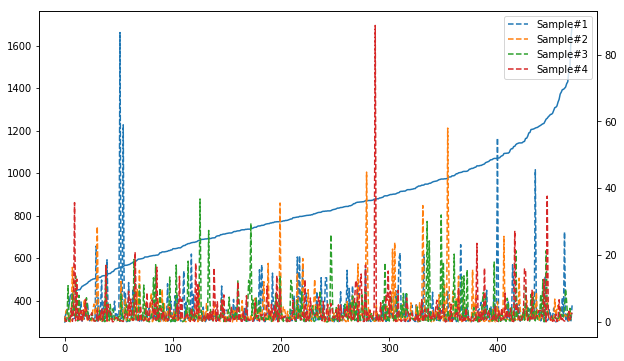

In [17]:
lib = np.sum(x_test.X, axis=1)
indices = np.argsort(lib)

# Original data is the continuous line
# Sample from the model is the dashed lines
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(lib[indices], label="Original Library")
ax = ax.twinx()
for i in range(4):
  # what is get is the log library
  s = np.exp(log_library.sample().numpy().ravel())
  ax.plot(s, linestyle='--', label="Sample#%d" % (i + 1))
ax.legend()

# Create and train semi-supervised model

The implementation of SISUA is `MultitaskVAE`

NOTE: similar semi-supervised approach to `DCA` and `scVI` are also available in SISUA as `MultitaskAutoEncoder` and `MultitaskVI` respectively.

Since there are two inputs to the semi-supervised models:

* The gene expression data `[n_samples, n_genes]`
* The protein marker data `[n_samples, n_proteins]`,

the arguments `units` and `xdist` must be provided as a list, respectively for each input 

* `units=[n_genes, n_prots]` and
* `xdist=['zinb', 'nb']`

Reference:

* [Trung Ngo Trong, Roger Kramer, Juha Mehtonen, Gerardo González, Ville Hautamäki, Merja Heinäniemi. "SISUA: SemI-SUpervised Generative Autoencoder for Single Cell Data", ICML Workshop on Computational Biology, 2019.](https://doi.org/10.1101/631382)

In [18]:
sisua = MultitaskVAE(units=[n_genes, n_prots],
                     xdist=['zinb', 'nb'],
                     nlayers=nlayers,
                     hdim=hdim,
                     zdim=zdim)
# Be generous with the number of epoch, since we use EarlyStopping,
# the algorithm will stop when overfitting
sisua.fit([x_train, y_train], epochs=epochs, verbose=True)

(imputation, protein), latent = sisua.predict(x_test)
print(imputation)
print(protein)
print(latent)

Epoch 1/64
60/60 [==============================] - 8s 128ms/step - loss: 1543.5023 - KLqp: 0.5687 - nllk_x: 1175.3689 - nllk_y: 422.6826 - val_loss: 1126.9299 - val_KLqp: 0.1835 - val_nllk_x: 1079.5931 - val_nllk_y: 47.3331
Epoch 2/64
60/60 [==============================] - 4s 62ms/step - loss: 1353.5772 - KLqp: 0.5799 - nllk_x: 1020.0931 - nllk_y: 375.8438 - val_loss: 1001.2298 - val_KLqp: 0.2187 - val_nllk_x: 958.6730 - val_nllk_y: 42.5522
Epoch 3/64
60/60 [==============================] - 4s 63ms/step - loss: 1210.8396 - KLqp: 0.5965 - nllk_x: 906.9771 - nllk_y: 336.3866 - val_loss: 901.3329 - val_KLqp: 0.2808 - val_nllk_x: 862.4537 - val_nllk_y: 38.8679
Epoch 4/64
60/60 [==============================] - 4s 62ms/step - loss: 1099.8444 - KLqp: 0.6037 - nllk_x: 818.3843 - nllk_y: 310.0499 - val_loss: 808.5087 - val_KLqp: 0.3453 - val_nllk_x: 772.5584 - val_nllk_y: 35.9297
Epoch 5/64
60/60 [==============================] - 4s 62ms/step - loss: 1015.7153 - KLqp: 0.6303 - nllk_x: 74

Predicting: 100%|██████████| 8/8 [00:00<00:00, 10.53it/s]

tfp.distributions.Independent("IndependentZeroInflated", batch_shape=[1, 470], event_shape=[1998], dtype=float32)
tfp.distributions.Independent("IndependentNegativeBinomial", batch_shape=[1, 470], event_shape=[12], dtype=float32)
tfp.distributions.Independent("IndependentNormal", batch_shape=[470], event_shape=[16], dtype=float32)


### Visualizing the predicted labels for semi-supervised model

Predicting: 100%|██████████| 30/30 [00:05<00:00,  5.92it/s]
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.
[Warning]Install MulticoreTSNE from `pip install git+https://github.com/DmitryUlyanov/Multicore-TSNE.git` to accelerate the T-SNE on multiple CPU cores.


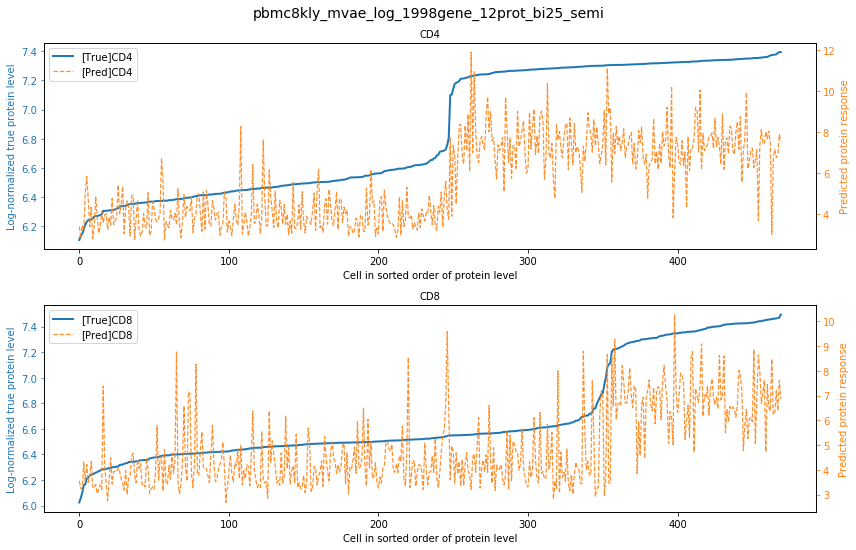

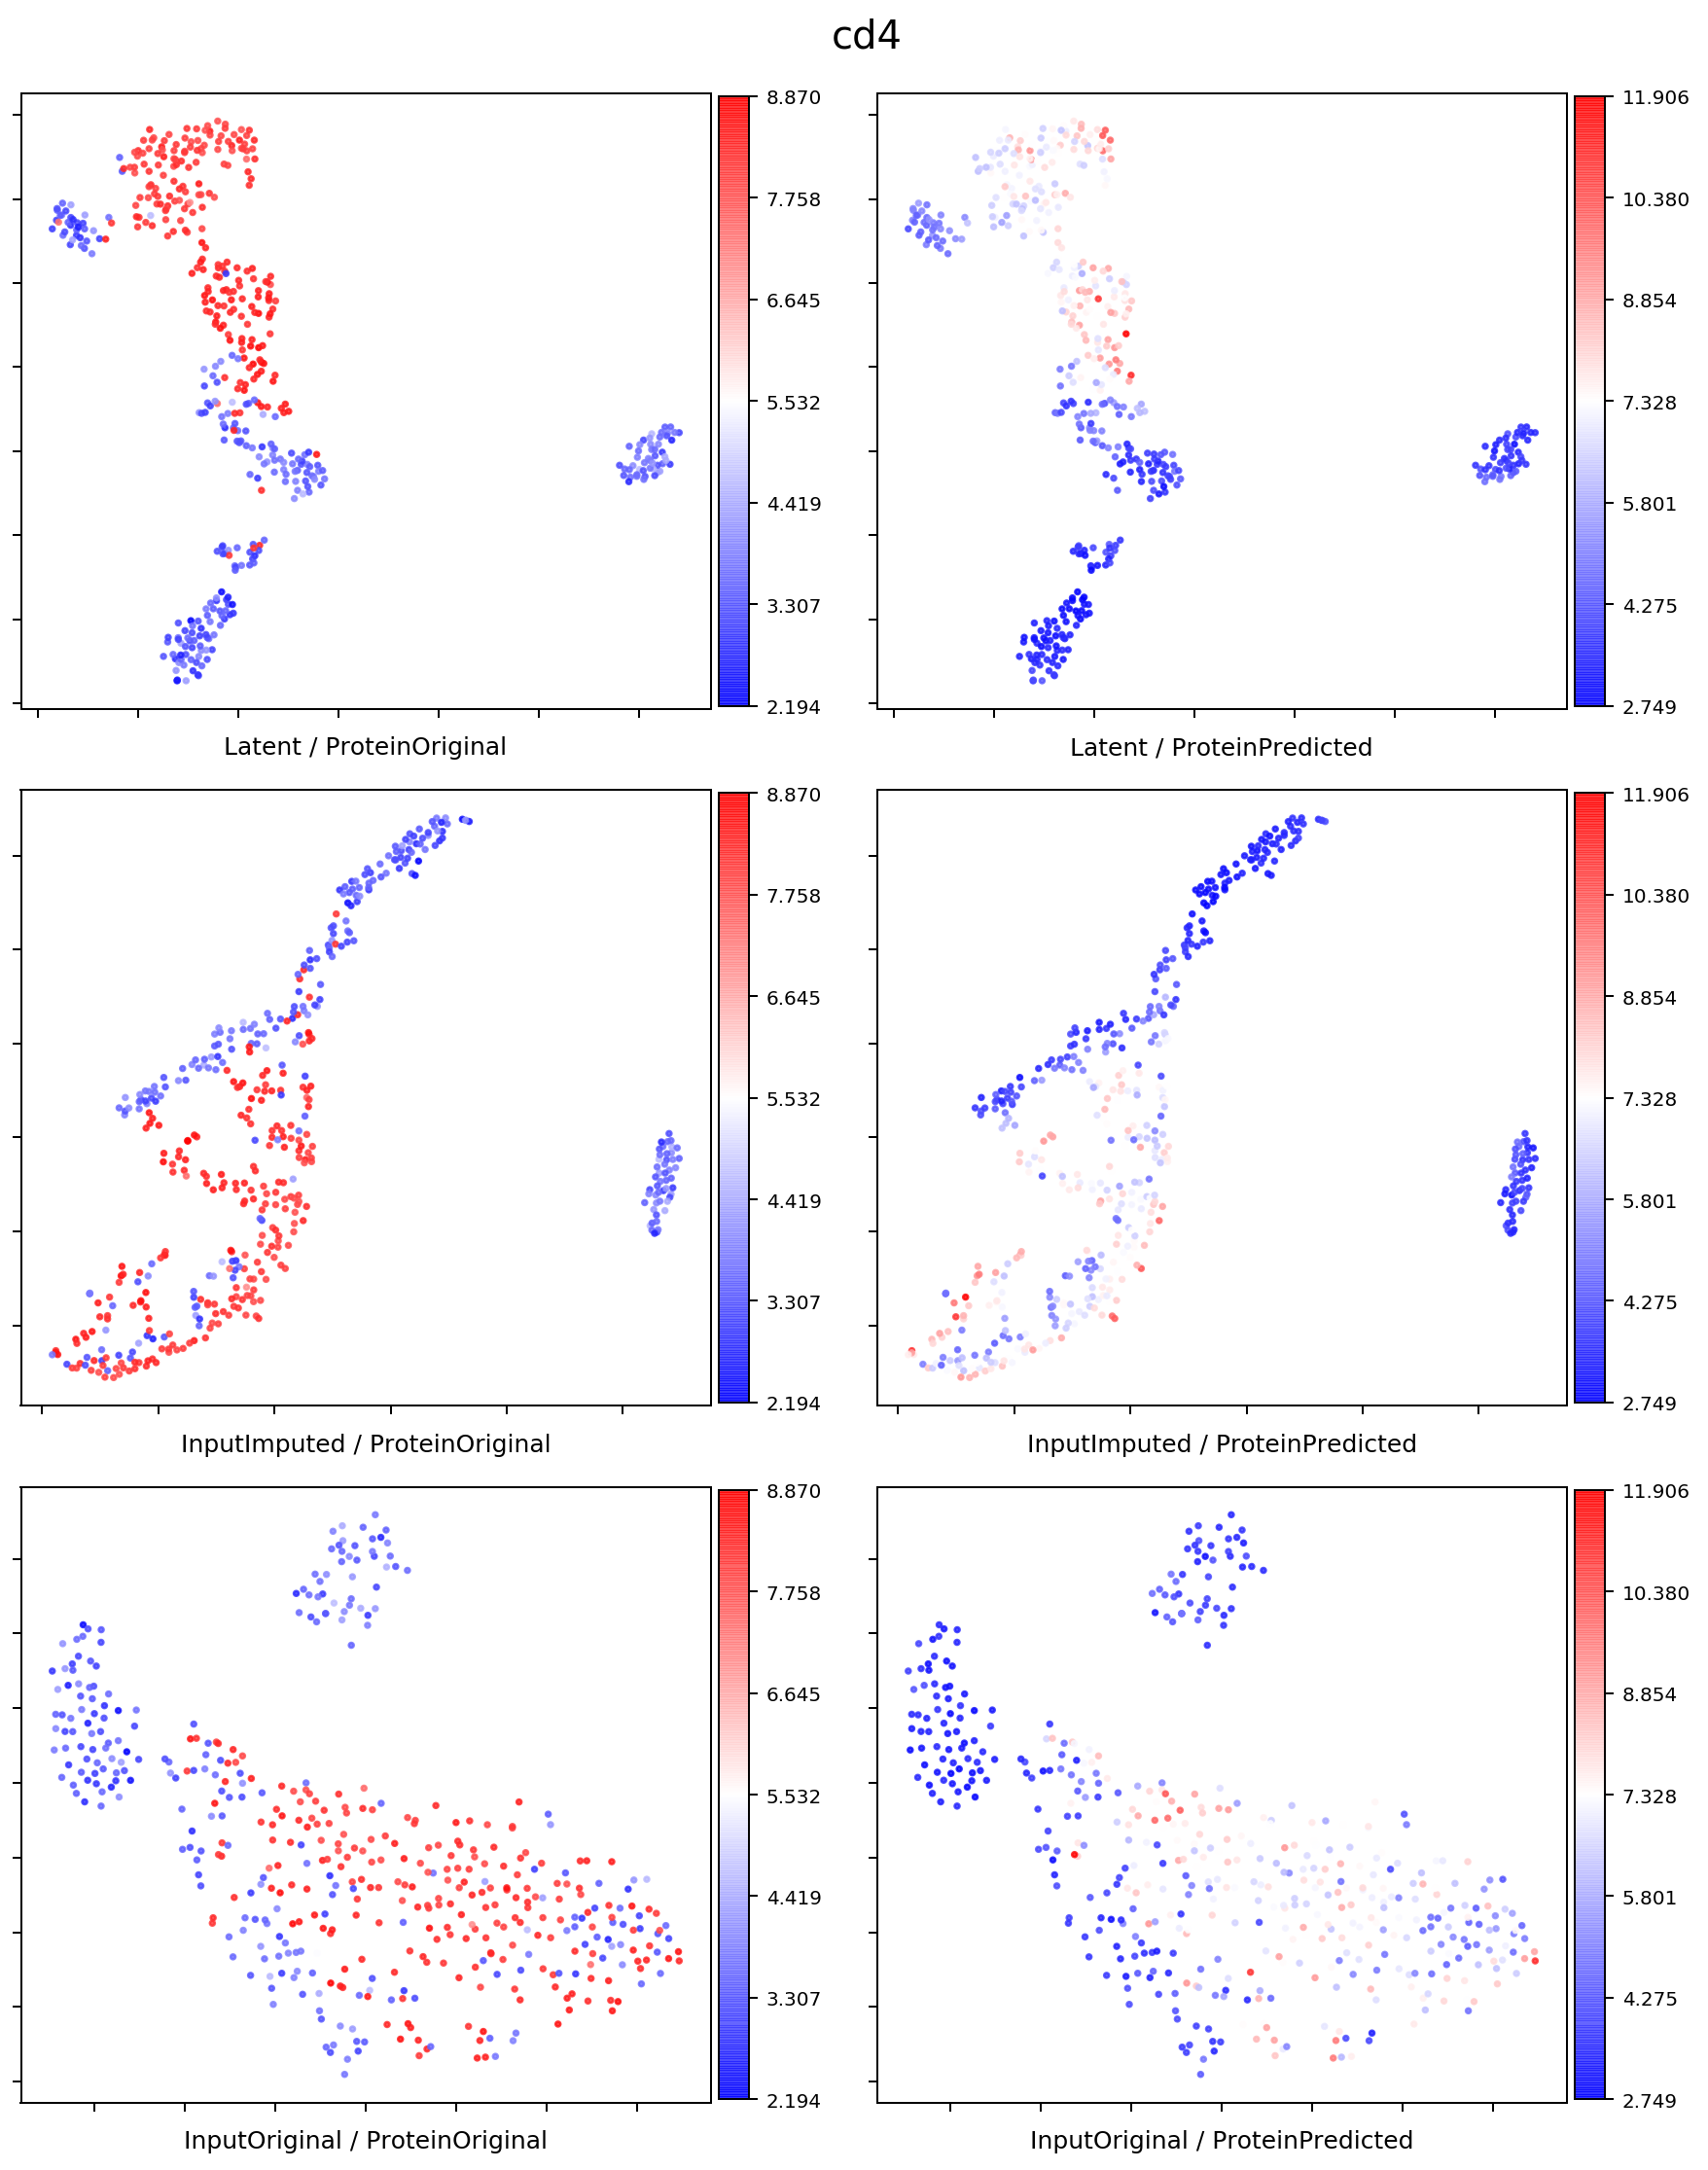

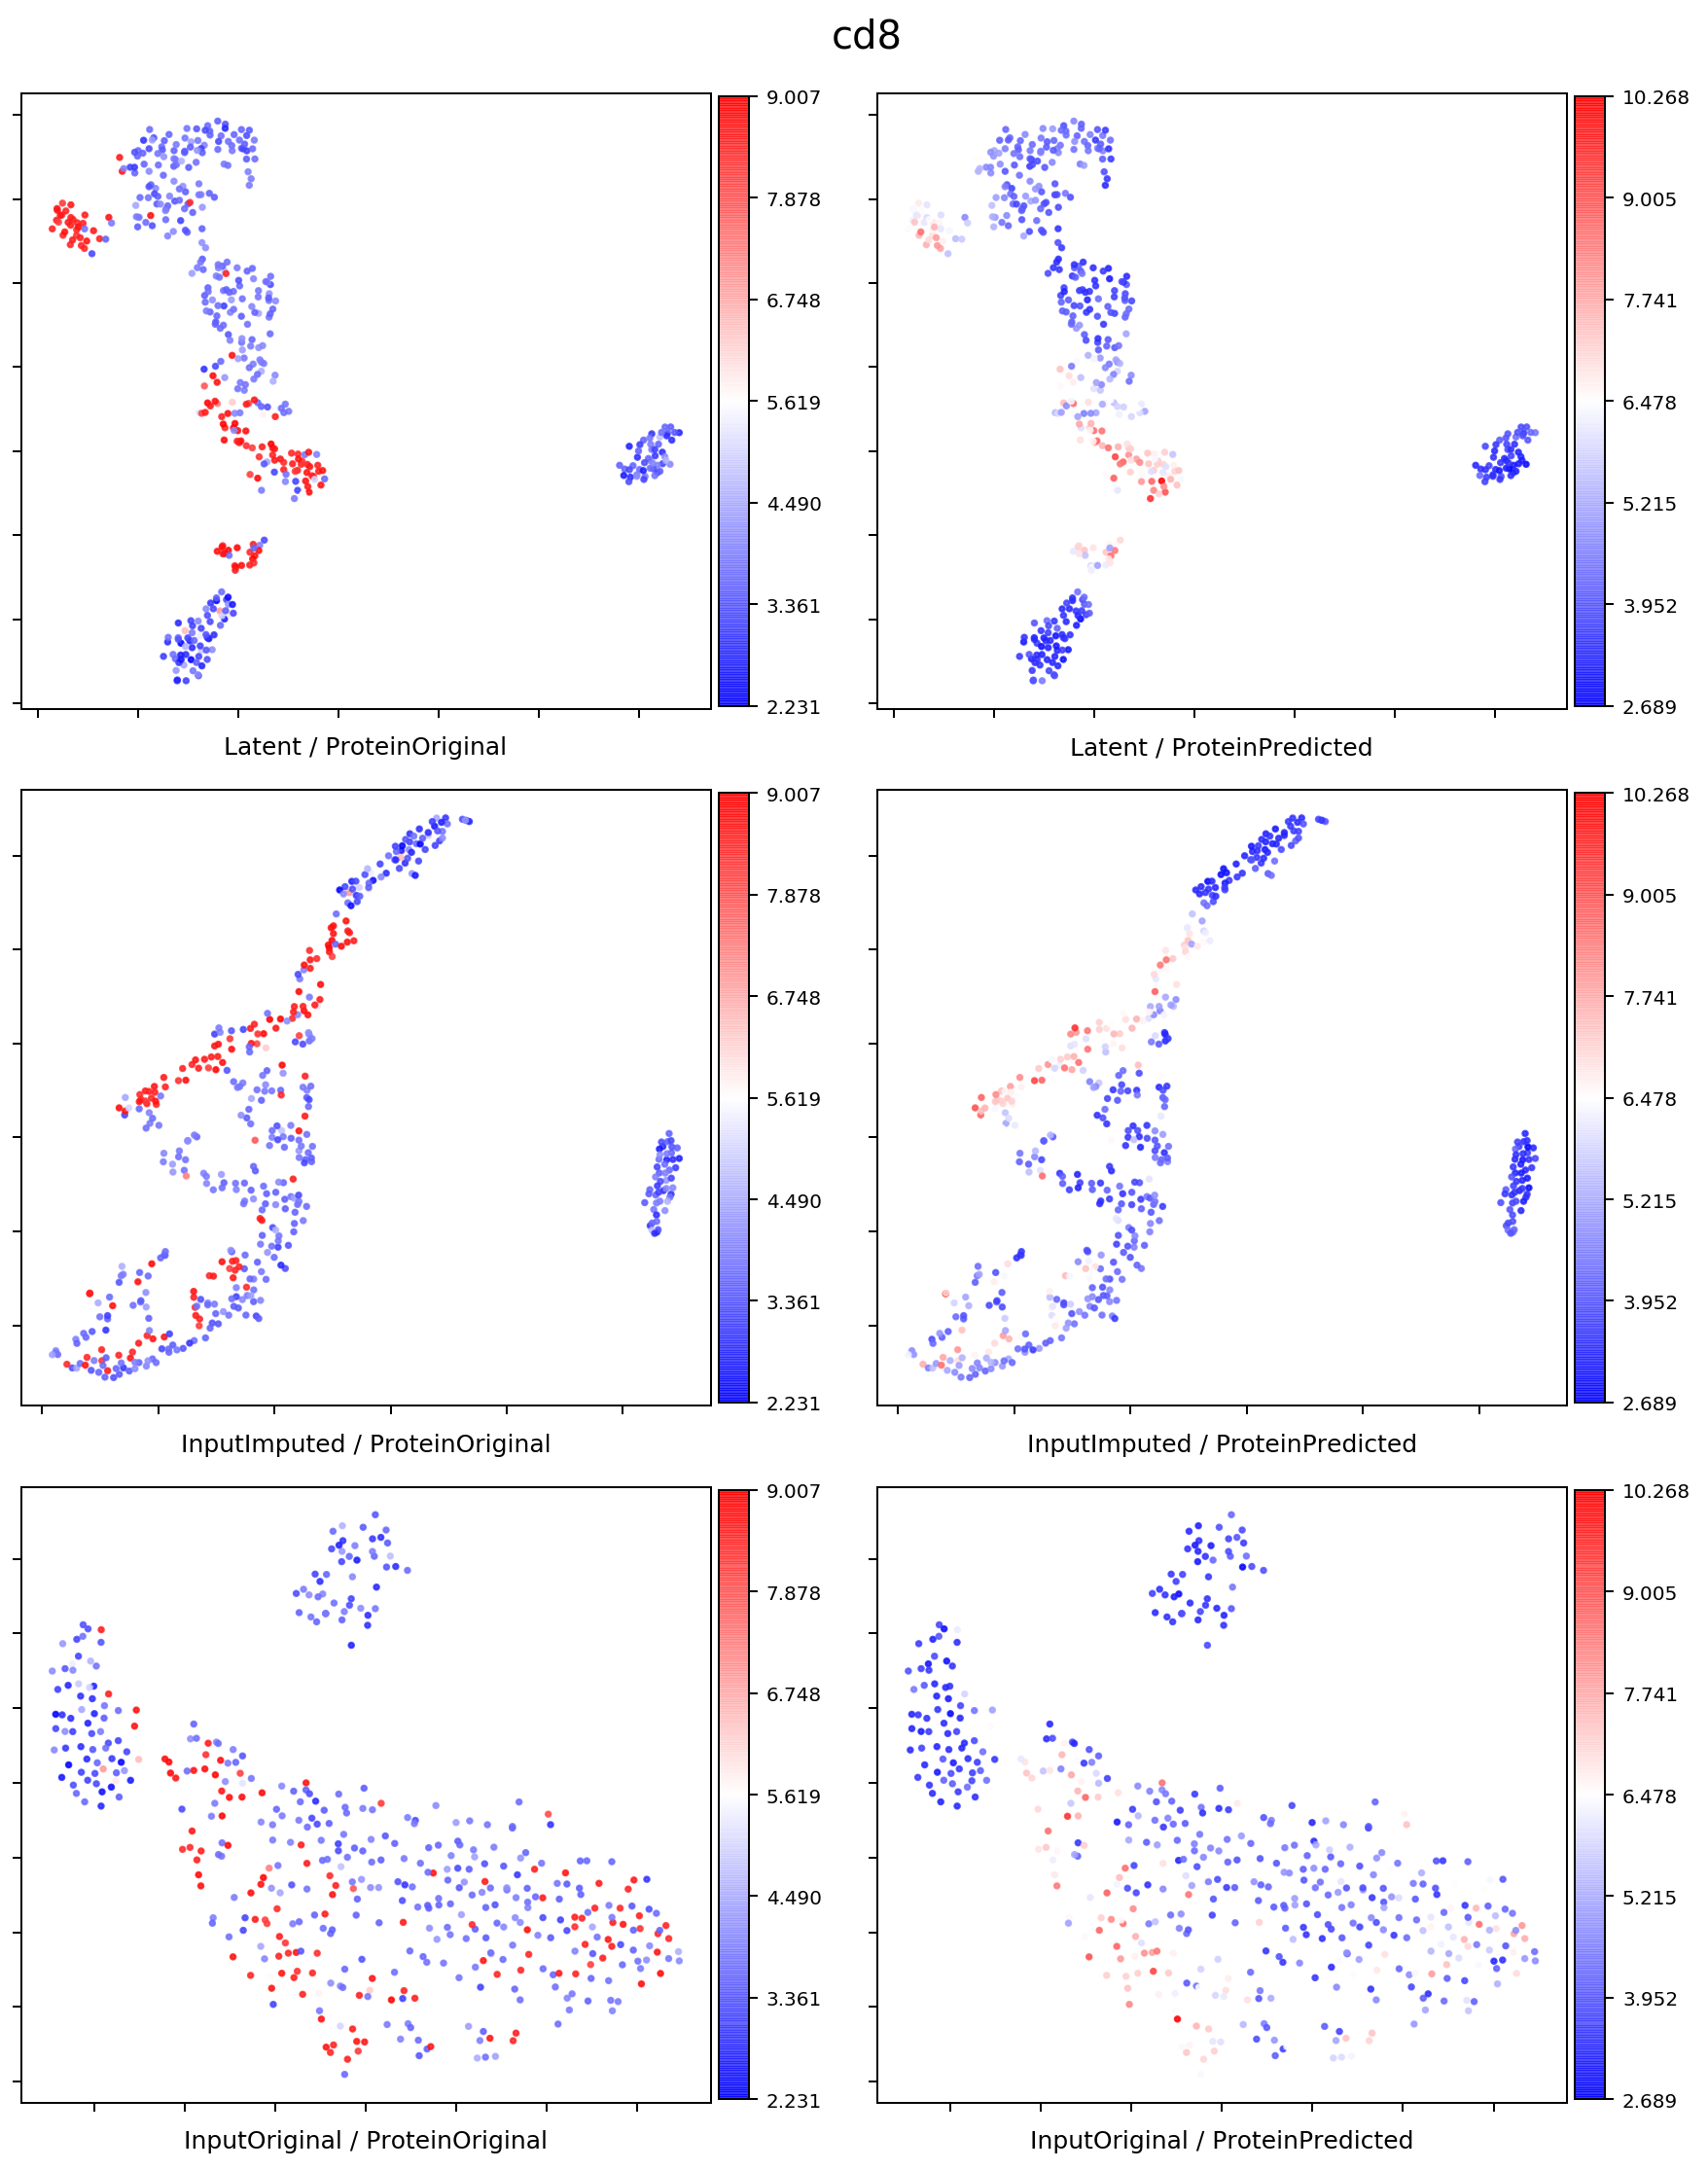

In [19]:
# only SISUA have the ability to make analysis for predicted protein levels
pos = Posterior(sisua, gene=x_test, protein=y_test, verbose=True)
pos.plot_protein_predicted_series(proteins=['cd4', 'cd8'])
pos.plot_protein_scatter(protein_name='CD4')
pos.plot_protein_scatter(protein_name='CD8')